In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

In [2]:
# Load and preprocess the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Resize and convert images to 3 channels
x_train = tf.image.resize(x_train[..., tf.newaxis], (32, 32))
x_train = np.repeat(x_train, 3, axis=-1)
x_test = tf.image.resize(x_test[..., tf.newaxis], (32, 32))
x_test = np.repeat(x_test, 3, axis=-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode the labels
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [3]:
# Load the VGG16 base model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

In [4]:
# Create the model
model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
# Train the model with the feature extraction base
history = model.fit(x_train, y_train, epochs=8, verbose=1, batch_size=64, validation_split=0.2)


Epoch 1/8
750/750 [==============================] - 128s 171ms/step - loss: 0.5660 - accuracy: 0.8013 - val_loss: 0.4671 - val_accuracy: 0.8301
Epoch 2/8
750/750 [==============================] - 135s 180ms/step - loss: 0.4191 - accuracy: 0.8463 - val_loss: 0.4196 - val_accuracy: 0.8493
Epoch 3/8
750/750 [==============================] - 138s 184ms/step - loss: 0.3831 - accuracy: 0.8582 - val_loss: 0.4080 - val_accuracy: 0.8531
Epoch 4/8
750/750 [==============================] - 139s 186ms/step - loss: 0.3601 - accuracy: 0.8685 - val_loss: 0.3876 - val_accuracy: 0.8583
Epoch 5/8
750/750 [==============================] - 140s 186ms/step - loss: 0.3420 - accuracy: 0.8752 - val_loss: 0.3760 - val_accuracy: 0.8642
Epoch 6/8
750/750 [==============================] - 141s 188ms/step - loss: 0.3266 - accuracy: 0.8801 - val_loss: 0.3743 - val_accuracy: 0.8644
Epoch 7/8
750/750 [==============================] - 141s 188ms/step - loss: 0.3129 - accuracy: 0.8853 - val_loss: 0.3841 - val_ac

In [6]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


313/313 [==============================] - 26s 82ms/step - loss: 0.3781 - accuracy: 0.8647
Test loss: 0.3780551254749298
Test accuracy: 0.8647000193595886


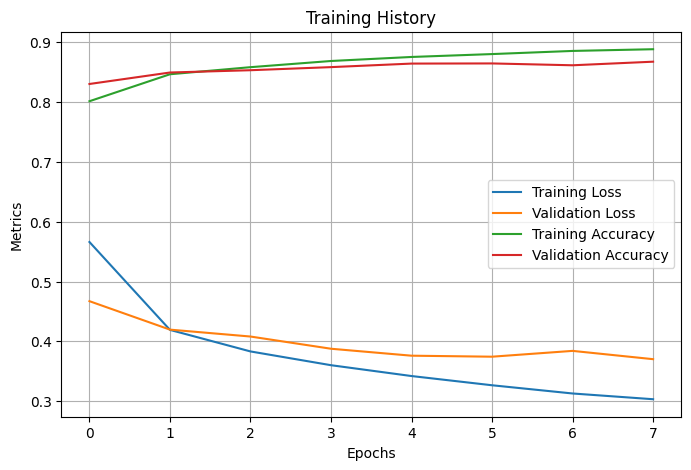

In [7]:
# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training History")
plt.legend()
plt.show()

In [8]:
# Print model summary
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [9]:
# Fine-tune the model by unfreezing some layers
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = True

In [10]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
# Create a new model 
fine_tuned_model = Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(10, activation="softmax"),
])

fine_tuned_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Train the fine-tuned model
history = fine_tuned_model.fit(x_train, y_train, epochs=2, verbose=1, batch_size=64, validation_split=0.2)


Epoch 1/2
750/750 [==============================] - 237s 316ms/step - loss: 0.4069 - accuracy: 0.8553 - val_loss: 0.3213 - val_accuracy: 0.8809
Epoch 2/2
750/750 [==============================] - 236s 315ms/step - loss: 0.2837 - accuracy: 0.8952 - val_loss: 0.2772 - val_accuracy: 0.8990


In [13]:
# Evaluate the fine-tuned model
test_loss, test_accuracy = fine_tuned_model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

313/313 [==============================] - 26s 83ms/step - loss: 0.2918 - accuracy: 0.8957
Test loss: 0.2917916476726532
Test accuracy: 0.8956999778747559


Порівнюючи отримані результати із результатами багатошарової нейронної мережі з попереднього завдання, ми можемо висунути наступні висновки:

1. Згорткова нейромережа, що використовує архітектуру VGG16, показала значно кращі результати на даних із датасету Fashion MNIST порівняно з багатошаровою мережею. Точність після донавчання досягла 89.90%, що є значно вище, ніж 86.76%, яку досягла багатошарова мережа після 50 епох навчання.

2. Згорткова нейромережа також має набагато менше втрат на валідаційному наборі після донавчання, що свідчить про її кращу загальну ефективність.

Отже, згорткова нейромережа, використовуючи архітектуру VGG16, є більш потужним і ефективним інструментом для класифікації даних з Fashion MNIST порівняно з багатошаровою мережею.